In [96]:
#packages importation
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model, load_model
import tensorflow as tf
import keras
from keras.preprocessing import image
from sklearn.model_selection import train_test_split

import random as rd

In [2]:
#create a np.array from the images
path = "C:/Users/toto9/OneDrive/Documents/4BIM S2/PROJET/10000faces/10000faces/"

imgs = []
for filemname in os.listdir(path):
    img = image.load_img(path+filemname, target_size = (128,128)) #resize to 128*128
    imgs.append(image.img_to_array(img))
imgs = np.array(imgs)

#imgs.shape

In [3]:
#split the data in train and test subsets
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(imgs, test_size=0.2, random_state=0)
print(X_train.shape)

(8000, 128, 128, 3)


In [70]:
#visualize data
def show_faces_data(X, n=10, title=""):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)


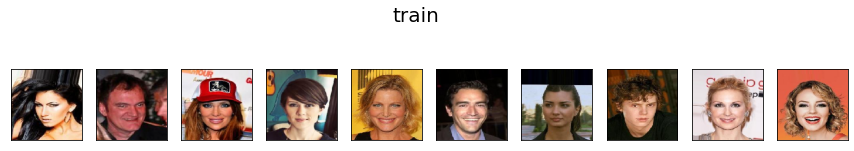

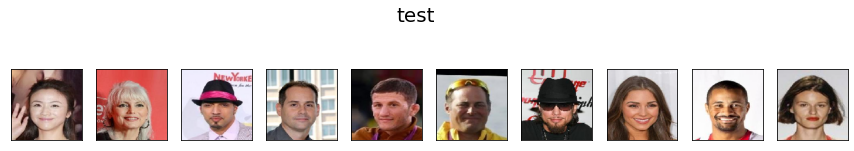

In [5]:
show_faces_data(X_train, title="train")
show_faces_data(X_test, title="test")
plt.show()

Max pooling : used to reduce the spatial dimensions of the output volume.
Conv2D :
first parameter : number of filters (number of kernels to convolve with the input volume. Each of these operations produces a 2D activation map)
then : filter_size : ex (3,3)

In [6]:
input_layer = Input(shape=(128, 128, 3), name="INPUT")
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

In [7]:
code_layer = MaxPooling2D((2, 2), name="CODE")(x)


In [8]:
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(code_layer)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
output_layer = Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [9]:
faces_AE = Model(input_layer, output_layer)
faces_AE.compile(optimizer='adam', loss='mse')
faces_AE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 8)         584   

In [10]:
faces_AE.fit(X_train, X_train,
                epochs=30,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/30
250/250 [==============================] - 207s 824ms/step - loss: 2427.7397 - val_loss: 895.9366
Epoch 2/30
250/250 [==============================] - 191s 762ms/step - loss: 721.2281 - val_loss: 641.1355
Epoch 3/30
250/250 [==============================] - 191s 764ms/step - loss: 587.9304 - val_loss: 567.8022
Epoch 4/30
250/250 [==============================] - 199s 797ms/step - loss: 535.9966 - val_loss: 526.6631
Epoch 5/30
250/250 [==============================] - 185s 739ms/step - loss: 506.9310 - val_loss: 506.0098
Epoch 6/30
250/250 [==============================] - 180s 719ms/step - loss: 488.6183 - val_loss: 486.8906
Epoch 7/30
250/250 [==============================] - 179s 716ms/step - loss: 474.7137 - val_loss: 473.3658
Epoch 8/30
250/250 [==============================] - 187s 747ms/step - loss: 461.9717 - val_loss: 467.3851
Epoch 9/30
250/250 [==============================] - 180s 720ms/step - loss: 451.6971 - val_loss: 452.2710
Epoch 10/30
250/250 [======

In [11]:
#Save auto-encoder 
faces_AE.save("C:/Users/toto9/OneDrive/Documents/4BIM S2/PROJET/faces_AE_bis2.h5")


In [12]:
#Make a model to get the encoded representation (i.e. intermediate layer output) of a given face picture
get_encoded_face = Model(inputs=faces_AE.input, outputs=faces_AE.get_layer("CODE").output)

In [13]:
#Get encoded faces
encoded_face = get_encoded_face.predict(X_test)
#we convert into a linear vector to make it easier to manage by the genetic algorithm
encoded_face = encoded_face.reshape((len(X_test), 16*16*8))
np.savetxt("C:/Users/toto9/OneDrive/Documents/4BIM S2/PROJET/encoded_faces_bis2.txt", encoded_face)


In [14]:
encoded_face.shape

(2000, 2048)

In [15]:
#Reconstructed faces
reconstructed_faces = faces_AE.predict(X_test)

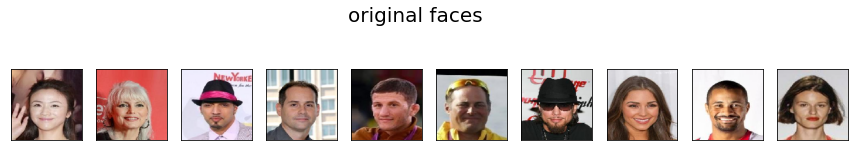

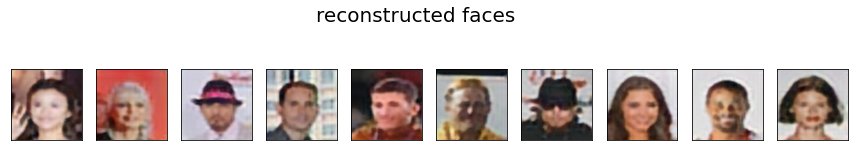

In [16]:
#Visualize the results on test set
show_faces_data(X_test, title="original faces")
#show_faces_data(encoded_face, height=32, width=64, title="encoded faces")
show_faces_data(reconstructed_faces, title="reconstructed faces")

# DECODER 

In [17]:
input_layer_deco = Input(shape=(16, 16, 8), name="INPUT")
hidden_decoder_layer_d = faces_AE.layers[-7]
hidden_decoder_layer_c = faces_AE.layers[-6]
hidden_decoder_layer_b = faces_AE.layers[-5]
hidden_decoder_layer_a = faces_AE.layers[-4]
hidden_decoder_layer = faces_AE.layers[-3]
hidden_dropout_decoded_layer = faces_AE.layers[-2]
decoder_layer = faces_AE.layers[-1]
decoder = Model(input_layer_deco,decoder_layer(hidden_dropout_decoded_layer(hidden_decoder_layer(hidden_decoder_layer_a(hidden_decoder_layer_b(hidden_decoder_layer_c(hidden_decoder_layer_d(input_layer_deco))))))))
decoder.compile(optimizer='adam', loss='mse')
decoder.save("C:/Users/toto9/OneDrive/Documents/4BIM S2/PROJET/faces_decoder_bis2.h5")

(2000, 2048)


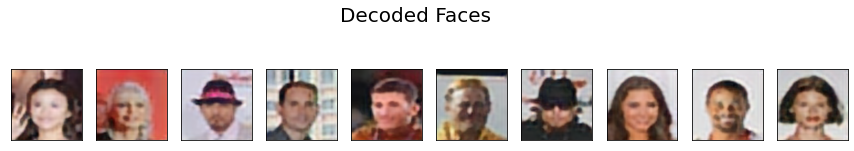

In [18]:
decoder_t = keras.models.load_model("C:/Users/toto9/OneDrive/Documents/4BIM S2/PROJET/faces_decoder_bis2.h5")
encoded_faces_0 = np.loadtxt("C:/Users/toto9/OneDrive/Documents/4BIM S2/PROJET/encoded_faces_bis2.txt")
print(encoded_faces_0.shape)
encoded_faces = encoded_faces_0.reshape(2000, 16, 16, 8)
decoded_faces = decoder_t.predict(encoded_faces)
show_faces_data(decoded_faces, title="Decoded Faces")

In [58]:
decoder_t = keras.models.load_model("C:/Users/toto9/OneDrive/Documents/4BIM S2/PROJET/faces_decoder_bis2.h5")
def decode_vector(vector, number_img, decoder_t):
    vector_load = np.loadtxt(vector)
    print(vector_load)
    encoded_faces = vector_load.reshape(number_img,16,16,8)
    decoded_vector = decoder_t.predict(encoded_faces)
    show_faces_data(decoded_vector, title = "Decoded Faces")
    

[[123.8449707  100.08472443 315.14373779 ...  24.02459717  27.65044403
   25.10574341]
 [168.5194397  155.71600342 282.72821045 ...  93.76169586  50.51000214
  111.63008118]
 [ 97.05900574 101.08531189 344.70278931 ... 101.89868927 108.69998169
  203.38363647]
 ...
 [106.54548645  97.957901   364.81985474 ... 139.92016602 123.55384827
  271.26855469]
 [ 89.88795471 128.54545593 232.7094574  ...  80.3372345   11.58256245
  116.15562439]
 [102.49032593  84.53186798 356.78735352 ...  88.32322693  73.9956131
  126.71632385]]


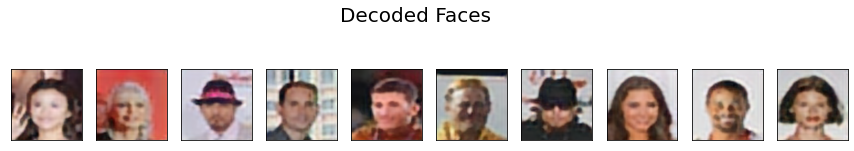

In [59]:
decode_vector("C:/Users/toto9/OneDrive/Documents/4BIM S2/PROJET/encoded_faces_bis2.txt", 2000, decoder_t)

In [88]:
def decode_one_vector(vector, number_img, decoder_t):
    print(vector)
    encoded_faces = vector.reshape(number_img,16,16,8)
    decoded_vector = decoder_t.predict(encoded_faces)
    show_faces_data(decoded_vector, n=1, title = "One Decoded Face")

[123.8449707  100.08472443 315.14373779 ...  24.02459717  27.65044403
  25.10574341]


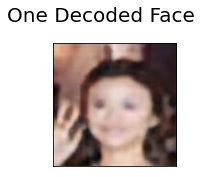

In [89]:
decode_one_vector(encoded_faces_0[0], 1, decoder_t)

In [151]:
def noise(Tm, pop, eps):
    ''' The noise function adds (or removes) epsilon to genes of the population's indivuals at rate Tm.

        Parameters
        ----------
        Tm : float between 0 and 1
            the mutation rate
        pop : np.array
            the selected individuals, whose genomes are lists of floats
        eps : float 
            the noise, amplitude of the mutation
        
        Returns
        -------
        mut_pop : np.array
            the population whose individuals underwent mutation
        
        >>> pop = np.array([rd.choices([-1,1],k=10),rd.choices([-1,1],k=10)])
        >>> pop
        [[ 1 -1 -1 -1  1  1 -1 -1 -1  1]
        [-1  1 -1 -1 -1  1 -1  1 -1  1]]
        >>> noise(0.5, pop, 5)
        [[ 1 -6  4  4  1  1 -1 -1  4  1]
        [-1  1 -6  4 -1  6 -6  6 -1  1]]
    '''
    mut_pop = np.copy(pop)
    #print(type(mut_pop))
    #print(np.size(mut_pop,0))
    for i_genome in range(np.size(mut_pop,0)):
        #print("\ncurrent genome : ", mut_pop[i_genome])
        for i_gene in range(np.size(mut_pop,1)):
            #print(mut_pop[i_genome][i_gene])
            if rd.random() <= Tm:
                #print("mutation")
                #mut_pop[i_genome][i_gene] = 0
                c = eps*np.random.normal(loc=0.0, scale=1.0, size=None) # à remplacer par np.random.randn ?
                mut_pop[i_genome][i_gene] = mut_pop[i_genome][i_gene] + c
                #print("mutated gene : ", mut_pop[i_genome][i_gene])
                #print("resulting genome : ", mut_pop[i_genome])
        #print("initial genome : ",pop[i_genome])
        #print("mutated genome : ",mut_pop[i_genome])
    return mut_pop

def crossing_over(P, Tc):
    ''' The crossing_over function does a crossing-over between two individuals' genomes at rate Tc.

        If there is crossing-over, there is an exchange between the genes of the genomes i and indc, chosen pseudo-randomly, from the posc position to the end of the genome.
        The posc position is also chosen pseudo-randomly.
        The genomes keep their initial length, because posc is identical for the genomes i and ind.

        Parameters
        ----------
        P : np.array
            the selected individuals, whose genomes are lists of floats
        Tc : float between 0 and 1
            the crossing-over rate

        Returns
        -------
        new_P : np.array
            the population whose individuals underwent crossing-over phenomenons. 
        
        >>> crossing_over(...) #A REMPLIR
    '''
    new_P = np.copy(P)
    
    for i in range(0,len(new_P)):
        if rd.random() < Tc:
            #print("it happened, at : ", i)
            #print(" before : ", new_P)
        
            indc = rd.randint(0, new_P.shape[0]-1) 
            #print("indc : ", indc)
            if indc == i :
                break
            posc = rd.randint(0, new_P.shape[1]-1) 
            #print("posc : ", posc)

            tmp = np.copy(new_P[i,posc:new_P.shape[1]])
            #print("tmp : \n", tmp)
            new_P[i,posc:new_P.shape[1]] = new_P[indc,posc:new_P.shape[1]]
            #print("during \n", new_P)
            #print("tmp : \n", tmp)
            #print("new_P[indc,posc:new_P.shape[1]]\n", new_P[indc,posc:new_P.shape[1]])
            new_P[indc,posc:new_P.shape[1]] = tmp
            #print("after : \n", new_P)
    return new_P

def crossing_over2(parents, Tc):
    ''' The crossing_over function does a crossing-over between two individuals' genomes at rate Tc.
        A METTRE A JOUR 
        If there is crossing-over, there is an exchange between the genes of the genomes i and indc, chosen pseudo-randomly, from the posc position to the end of the genome.
        The posc position is also chosen pseudo-randomly.
        The genomes keep their initial length, because posc is identical for the genomes i and ind.

        Parameters
        ----------
        Parents : list
            parents, list of np.arrays
        Tc : float between 0 and 1
            the crossing-over rate

        Returns
        -------
        child : np.array
            the population whose individuals underwent crossing-over phenomenons. 
        
        >>> crossing_over(...) #A REMPLIR
    '''
    children = np.copy(parents)
    
    for pos in range(0,children.shape[1]-1): # on parcoure le génome du parent 1, avec une chance Tc d'avoir crossing-over
        if rd.random() < Tc:
            #print("it happened, at : ", i)
            #print(" before : ", new_P)
            tmp = np.copy(children[0,pos:])
            #print("tmp : \n", tmp)
            children[0,pos:] = children[1,pos:]
            #print("during \n", new_P)
            #print("tmp : \n", tmp)
            #print("new_P[indc,posc:new_P.shape[1]]\n", new_P[indc,posc:new_P.shape[1]])
            children[1,pos:] = tmp
            #print("after : \n", new_P)
    return rd.choice(children) # on a créé 2 enfants, on en choisit un pseudo-aléatoirement


def mean_genome(pop, Tmoy):
    ''' The mean_genome function returns the mean of random pairs of genomes from the selected population.
        
        Parameters
        ----------
        pop : np.array
            the selected individuals, whose genomes are lists of ints
        
        Returns
        -------
        mean_pop : np.array
            the population of mean individuals
    '''
    mean_pop = []
    for i in range(0,len(pop)):
            if rd.random() < Tmoy:
                #print("it happened, at : ", i)
                #print(" before : ", new_P)
            
                indc = rd.randint(0, pop.shape[0]-1) 
                #print("indc : ", indc)

                if indc == i :
                    break
                

                mean_pop.append(np.mean(k) for k in zip(pop[i], pop[indc]))

    return list(set(mean_pop))

##### POPULATION FUNCTION #####

# on ne veut pas reproposer les mêmes images que la génération précédente -> on doit s'assurer que les images de la nouvelle génération sont bien nouvelles
# critère de distance ? sur + d'images générées que nécessaire
# population qu'on va muter -> images sélectionnées 
# une image -> que bruit
# 2 images -> multiplier par 3 pour avoir 6 images -> bruit sur tout -> crossing over -> + 1 enfant qui remplace une des images ?
# fonction coût qui détermine la distance des images générées à celles sélectionnées -> 

def cost(l1,l2):
    ''' The cost function returns the distance (Frobenius Norm) between two numpy.arrays, using the function numpy.linalg.norm.
        
        Parameters
        ----------
        l1 : np.array
            a selected genome
        l2 : np.array
            another selected genome
        
        Returns
        -------
        np.linalg.norm(l1 - l2) : float
            Frobenius norm between l1 and l2
    '''
    return np.linalg.norm(l1 - l2)

def cost_pop(pop1, pop2):
    ''' The cost_pop function returns the distance matrix af two population containing numpy.arrays, using the function numpy.linalg.norm.
        
        Parameters
        ----------
        pop1 : np.array
            a population, whose genomes are np.arrays
        pop2 : np.array
            another population, whose genomes are np.arrays
        
        Returns
        -------
        distance_matrix : 2D np.array
            matrix whose values represent distances between pop1 and pop2 genomes
    '''
    distance_matrix = np.zeros((len(pop1), len(pop2))) # lignes : len(pop1) ; colonnes : len(pop2)
    for l in len(pop1):
        for c in len(pop2):
            if pop1[l] != pop2[c]:
                distance_matrix[l,c] = cost(pop1[l],pop2[c])
    return distance_matrix

# cost between selected and generated pop, or also within generated pop ?


def children_selection(parents, new_pop):
    ''' The children_selection function returns the .
        
        Parameters
        ----------
        parents : np.array
            a population, whose genomes are np.arrays
        new_pop : np.array
            a population, whose genomes are np.arrays, generated with mutations
        
        Returns
        -------
        children : np.array
            matrix whose values represent distances between pop1 and pop2 genomes
    '''
    children = []
    # is a genome too close to others in general ? -> sum 
    
    # is a genome too close to another generated genome ?
    distance_parents = cost_pop(parents, new_pop) # distances between the parents' genomes and the generated ones
    distance_children = cost_pop(new_pop, new_pop) # distances among the generated genomes
    index = []
    # à compléter
    return np.array(children)

def add_ind(pop, ind, pop_size):
    ''' The add_ind function adds a np.array to another np.array, in function of what the additional one contains.
        
        The np.array we want to add to the list can contain one or more genomes. How we add those genomes to the given list depends on this number of genomes. 
        We distinguish the way we add 1 genome and at least 2 genomes. 

        Parameters
        ----------
        pop : list
            a population, which can contain genomes as np.arrays
        ind : np.array
            a population, which contains one or more genomes as np.arrays
        pop_size : int
            the maximum number of individuals of the population
        
        
        Returns
        -------
        new_pop : list
            the newly created population which contains the genomes of pop and ind
    '''
    # we check we want to add multiple individuals, which are in a np.array, or just one individual
    # there is a maximum of pop_size individuals we want to add
    # if the length of the "ind" is superior to pop_size, it means what's inside is the genes (64) of the individual and not a np.array reprensenting the genome
    # pop is  a list
    new_pop = pop.copy()
    if len(ind)>=6 : # one individual
        new_pop.append(ind)
    else : # there are multiple individuals
        for individual in ind:
            new_pop.append(individual)
    return new_pop

def mean_genome2(parents):
    return np.mean(parents, axis=0)

#def new_generation(pop, Tm, Tc, Tmoy, eps):
def new_generation(pop, fitness, eliteCount, crossoverFraction, Tc, Tm, pop_size, eps):
    ''' The new_generation function returns the newly generated population according to the choices the user made and given rates.

        The new generation is composed of a given number of elite children, crossing-over children and mutation children. 
        
        
        Parameters
        ----------
        pop : np.array
            a population of size pop_size, whose genomes are np.arrays
        fitness : np.array
            a np.array containing the fitness values of the individuals of the population, in the same order. The fitness is determined by the user choices.
        eliteCount : int
            number of individuals with the best fitness values that are guaranteed to survive to the next generation
        crossoverFraction : float between 0 and 1
            fraction of individuals in the new generation, other than elite children, that are created by crossover
        Tc : float between 0 and 1 
            crossing-over rate
        Tm : float between 0 and 1
            mutation rate, usually around 1/length of the genome
        pop_size : int
            the number of picture presented to the user at each generation
        eps : float
            the noise, amplitude of the mutation
        
        Returns
        -------
        new_pop : np.array
           the generated next generation, containing pop_size genomes
    '''
    # fitness: list of fitness -> link with the IHM (selected -> 9, not selected -> 1 for example) in the same order as the pop individuals
    new_pop = []
    # Elite individuals
    Pc=np.copy(pop)
    index_sort = np.argsort(fitness,axis=0)
    sorted_pop = Pc[index_sort] # on trie les individus par fitness décroissante
    elite_pop = sorted_pop[0:eliteCount] # -> raise error if > len(pop) ?
    new_pop = add_ind(new_pop, elite_pop, pop_size)
    # THINK OF A MORE EFFICIENT WAY + make a function ?

    # Crossing over children
    nb_crossover = int((len(pop)-eliteCount)*crossoverFraction)
    for i in range(nb_crossover):
        parents = rd.choices(pop, weights=fitness, k=2)
        new_pop = add_ind(new_pop, crossing_over2(parents, Tc), pop_size)

    # Fill the new pop
    nb_mutated = int(pop.shape(0) - eliteCount - nb_crossover) #number of individuals who only undergo mutation
    mutated = rd.choices(pop, weights=fitness, k=nb_mutated)
    new_pop = add_ind(new_pop, mutated, pop_size)

    # Apply mutation (noise)
    # usually, Tm = 1/len(genome)
    new_pop = noise(Tm, new_pop[eliteCount:], eps)

    return np.array(new_pop)

def first_generation(pop_size, ind_length, mu, sigma):
    ''' The first_generation function creates a population composed of pseudo-randomly generated vectors.
        
        Parameters
        ----------
        pop_size : int
            size of the population, number of individuals it contains
        ind_length: int
            length of one individual's genome
        E : float
            the noise, amplitude of the values the genes can take
        
        Returns
        -------
        np.array(pop) : np.array
           the generated population, containing pop_size individuals whose genomes contain ind_length genes
    '''
    pop = []
    for ind in range(pop_size):
        pop.append([np.random.normal(loc=mu, scale=sigma, size=None) for i in range(ind_length)])
    return np.array(pop)

In [152]:
pop = np.array([rd.choices([-2,2],k=10),rd.choices([-1,1],k=10)])
print(pop,'\n')
popm = noise(0.5, pop, 5)
print("noise:\n",popm,'\n')
#popmc = crossing_over2(popm, 0.5)
#print("crossing over:\n",popmc)
print([i for i in range(10)])
# print(mean_genome(popmc, 0.5))

encoded_faces_0 = np.loadtxt("C:/Users/toto9/OneDrive/Documents/4BIM S2/PROJET/encoded_faces_bis2.txt")
print(encoded_faces_0[0:2])


encoded_faces_0_mean = mean_genome2(encoded_faces_0[3:5])
encoded_faces_0_crossed = crossing_over2(encoded_faces_0[3:5], 1)
print(encoded_faces_0_crossed)

decoder_t = keras.models.load_model("C:/Users/toto9/OneDrive/Documents/4BIM S2/PROJET_V2/Projet_SD/faces_decoder_bis2.h5")

[[-2 -2  2  2 -2 -2 -2 -2  2  2]
 [-1 -1  1  1 -1  1 -1 -1 -1  1]] 

noise:
 [[-2 -9  2  2 -2 -1 -2 -2  3  2]
 [-3 -1  0  2 -1  4 -1 -7 -1  1]] 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[[123.8449707  100.08472443 315.14373779 ...  24.02459717  27.65044403
   25.10574341]
 [168.5194397  155.71600342 282.72821045 ...  93.76169586  50.51000214
  111.63008118]]
[ 13.5166235   61.87620544  35.65194321 ... 163.97546387   9.20062542
  43.9980278 ]


In [153]:
print(encoded_faces[0].shape)

(16, 16, 8)


[ 37.8907485   36.15909672 132.52934837 ... 103.31418037  56.55933523
 150.87224388]
[ 13.5166235   61.87620544  35.65194321 ... 163.97546387   9.20062542
  43.9980278 ]


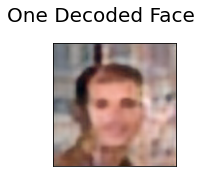

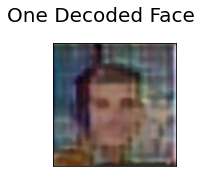

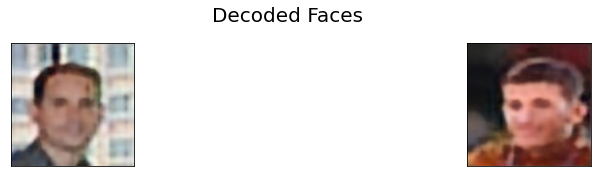

In [154]:
def decode_one_vector(vector, number_img, decoder_t):
    print(vector)
    encoded_faces = vector.reshape(number_img,16,16,8)
    decoded_vector = decoder_t.predict(encoded_faces)
    show_faces_data(decoded_vector, n=1, title = "One Decoded Face")

decode_one_vector(encoded_faces_0_mean,1, decoder_t)
decode_one_vector(encoded_faces_0_crossed,1,decoder_t)
show_faces_data(decoded_faces[3:5],2, title="Decoded Faces")

[[255.49385753  49.74951019 102.02828953 ... 149.90073632 154.76071407
  204.55028021]
 [119.22080032  61.49127272 211.34604024 ... 101.28735146  54.74602383
   61.86748058]]


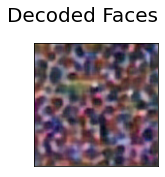

In [185]:
a = first_generation(2, 2048, 150, 75)
print(a)

a1_reshape = a[1].reshape(1,16,16,8)
decoded_vector_1 = decoder_t.predict(a1_reshape)

show_faces_data(decoded_vector_1,1, title="Decoded Faces")


(2, 128, 128, 3)
(2, 49152)
[[[160.  141.5 119.5]
  [159.  140.5 118.5]
  [160.  141.5 119.5]
  ...
  [163.5 152.  141. ]
  [161.  150.5 142. ]
  [169.  159.5 148. ]]

 [[160.  141.5 120.5]
  [159.  140.5 118.5]
  [160.  141.5 119.5]
  ...
  [163.5 152.5 141.5]
  [163.  152.5 144. ]
  [169.5 160.  148.5]]

 [[159.5 142.  120.5]
  [158.5 141.  119.5]
  [159.5 142.  120.5]
  ...
  [159.5 149.  138.5]
  [164.  154.5 145.5]
  [169.5 160.  148.5]]

 ...

 [[198.5 167.  146.5]
  [198.  166.  147. ]
  [179.  147.  129. ]
  ...
  [116.5  69.   54. ]
  [115.5  72.   57. ]
  [125.   87.5  72. ]]

 [[175.5 142.5 123.5]
  [183.5 149.5 131. ]
  [184.  149.5 132.5]
  ...
  [123.5  71.5  55. ]
  [122.5  73.5  57.5]
  [134.   92.5  76. ]]

 [[197.5 162.5 144.5]
  [230.  195.5 177. ]
  [226.  191.  174. ]
  ...
  [130.   75.   58.5]
  [129.5  77.5  60. ]
  [129.5  84.5  68. ]]]


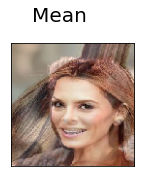

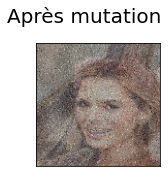

In [230]:
print(imgs[0:2].shape)
imgs0_bis = imgs[0:2].reshape(2,128*128*3)
print(imgs0_bis.shape)

encoded_faces_0_mean = mean_genome2(imgs[0:2])
print(encoded_faces_0_mean)

show_faces_data(encoded_faces_0_mean.reshape(1,128,128,3),1,"Mean")

thomas = noise(0.5, encoded_faces_0_mean, 50)
show_faces_data(thomas.reshape(1,128,128,3),1,"Après mutation")
